In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import numpy as np
import itertools, os
from scipy.stats import pearsonr
from tqdm import tqdm

In [15]:
cell_lines = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
track_index = [i for i, t in enumerate(target_df['description']) if
       ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                       'GM12878 ENCODE, biol_',
                                                       'PC-3'])]

cell_line_info = {}
for target_cell_line in cell_lines:
    cell_line_info[target_cell_line] = {}
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]
    
    
    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(track_index) == t).flatten()[0] for t in
                                                  targets]
    cell_line_info[target_cell_line]['target'] = '&'.join([str(t) for t in targets])

In [16]:
for cell_line in ['K562', 'GM12878', 'PC-3']:
    borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{cell_line}*selected_genes.csv')[0])
    enformer_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/enformer/*{cell_line}_selected_genes.csv')[0])
    N = len(list(set(borzoi_selected_genes['gene_name'].values).intersection(set(enformer_selected_genes['gene_name'].values))))
    print(f"Number of overlapping top selected genes in {cell_line} = {N}")

Number of overlapping top selected genes in K562 = 8730
Number of overlapping top selected genes in GM12878 = 8771
Number of overlapping top selected genes in PC-3 = 7752


In [46]:
model_name = 'borzoi'
threshold_enh, threshold_neu, threshold_sil = 0.7, 0.05, -0.3

res = []
for i, c in enumerate(cell_lines):
    selected_tss_path = glob.glob(f'../results/summary_csvs/enformer/*{c.split()[0]}*_selected_genes.csv')[0]
    cell_name = selected_tss_path.split('_')[-3]
    delta_means = []
    wt_means = []
    paths = []
    print(cell_name)
    selected_tss = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{c}*selected_genes.csv')[0])

    
    # selected_tss = pd.read_csv(selected_tss_path)
    # borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{c}*selected_genes.csv')[0])
    # selected_tss = selected_tss.merge(borzoi_selected_genes, on=['gene_name', 'Start'], suffixes=['', '_borzoi'])
    
    for _, row in selected_tss.iterrows():
        
        r = f'../results/context_dependence_test_10/{model_name}/{utils.get_summary(row)}.pickle'
        if os.path.isfile(r):
            with open(r, 'rb') as handle:
                context_res = pickle.load(handle)
            wt = context_res['wt'][:,cell_line_info[c]['output']].mean()
            mut = context_res['mut'][:,cell_line_info[c]['output']].mean()
            delta = (wt - mut) / wt
            delta_means.append(delta.mean())
            wt_means.append(wt.mean())
            paths.append(r)
        
    df = pd.DataFrame([delta_means, paths]).T
    df.columns = ['delta_mean', 'path']
    df['wt'] = wt_means
    df['context'] = [v for v in pd.cut(df['delta_mean'], 
                                       [df['delta_mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta_mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell_line'] = c.split()[0]
    
    print(df.shape)
    res.append(df)

res = pd.concat(res)
    

K562
(12322, 5)
GM12878
(12508, 5)
PC-3
(12732, 5)


11556     1.000977
11557     1.000977
11558     1.000977
11559     1.000977
11560     1.001953
           ...    
19955    41.093750
19956    41.125000
19957    41.937500
19958    42.031250
19959    44.000000
Name: PC-3, Length: 8404, dtype: float64

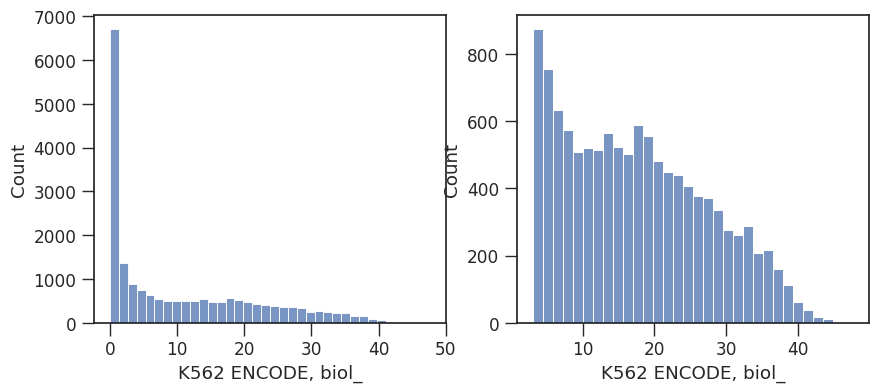

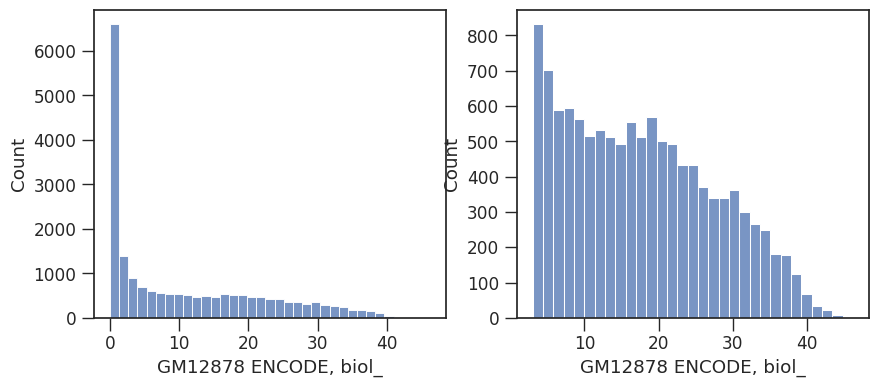

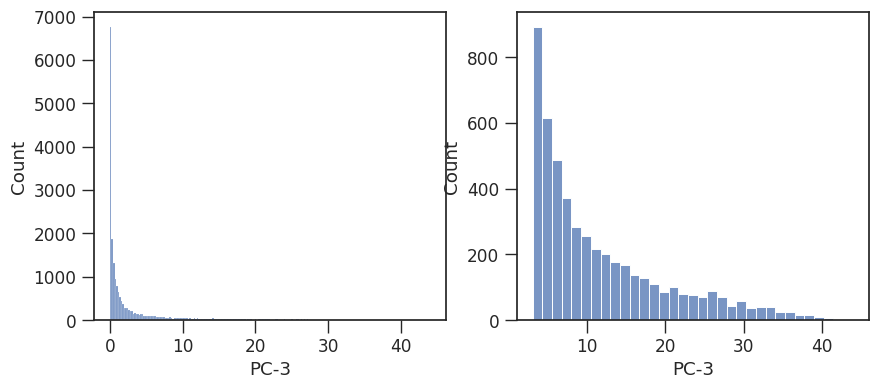

In [69]:
for c in ['K562', 'GM12878', 'PC-3']:
    fig, axes = plt.subplots(1, 2, figsize=[10, 4])
    selected_tss = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{c}*selected_genes.csv')[0])
    x = selected_tss.iloc[:,-1]
    sns.histplot(x=x, ax=axes[0])
    sns.histplot(x=x[x>3], ax=axes[1])
    # plt.hist(selected_tss.iloc[:,-1])


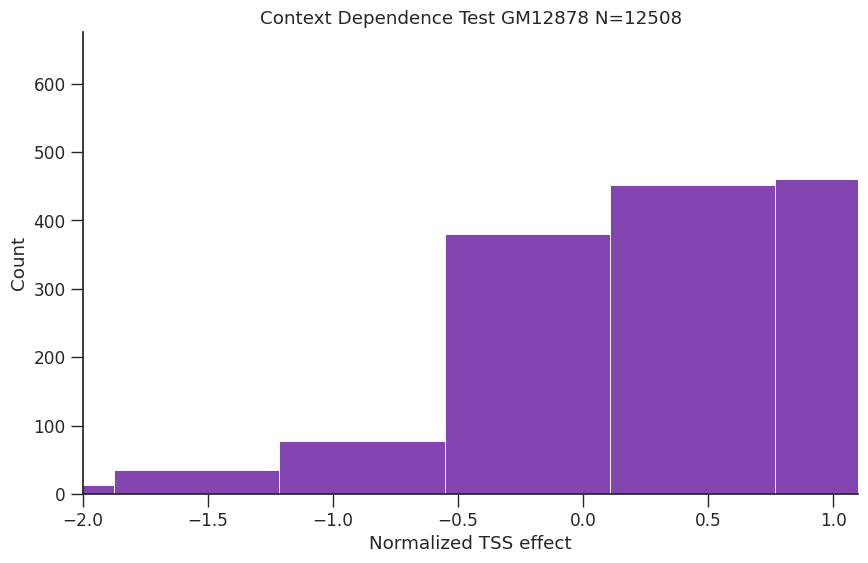

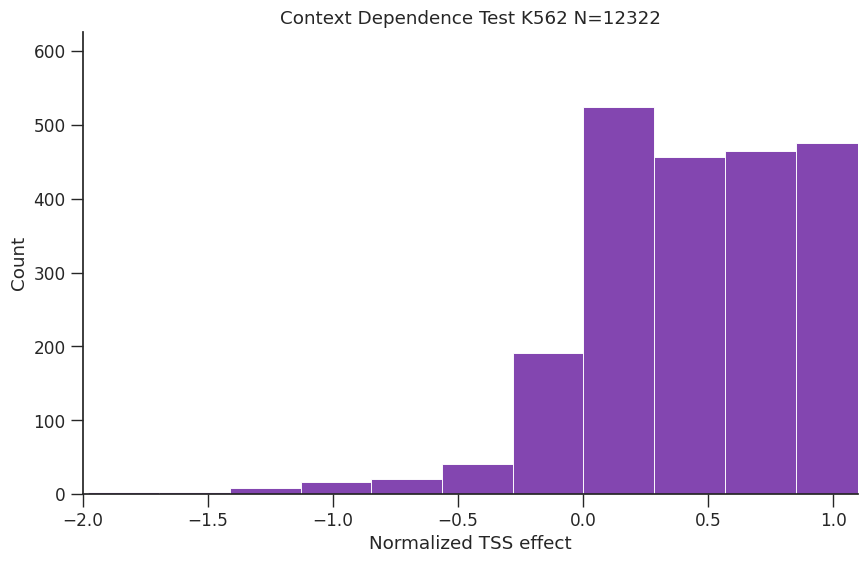

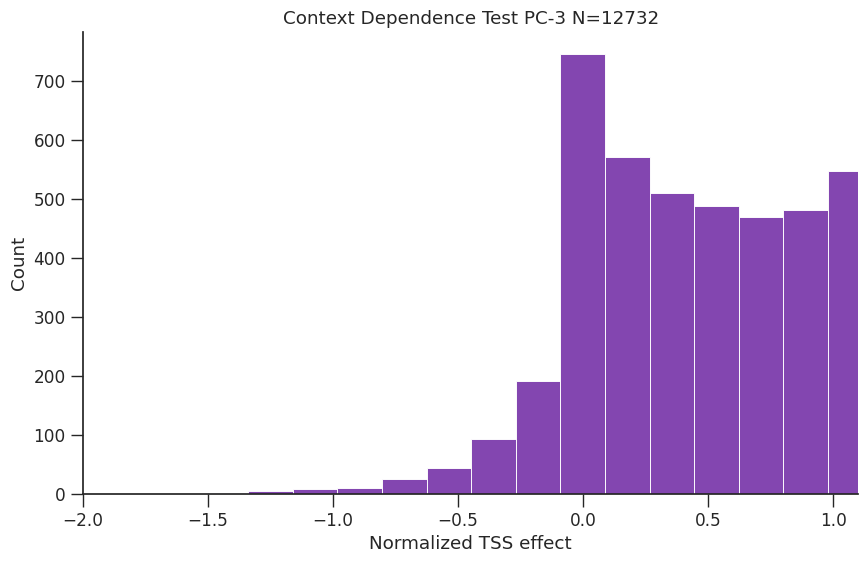

In [73]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell_line'):
    # df = df[(df['delta_mean'] > -10) & (df['wt'] > 3)]
    fig = plt.figure(figsize=[10, 6])

    df['WT - M'] = df['delta_mean'] * df['wt']

    ax = sns.histplot(x=df['WT - M'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    plt.xlim([-2,1.1])
    # plt.xticks([-2, -1, 0, 1])
    # plt.yticks([100, 200, 300])
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


(1903, 5)
(58, 5)
(7, 5)
['enhancing (N=200)', 'neutral (N=58)', 'silencing (N=7)']
(2460, 5)
(54, 5)
(8, 5)
['enhancing (N=200)', 'neutral (N=54)', 'silencing (N=8)']
(1391, 5)
(132, 5)
(240, 5)
['enhancing (N=200)', 'neutral (N=132)', 'silencing (N=200)']


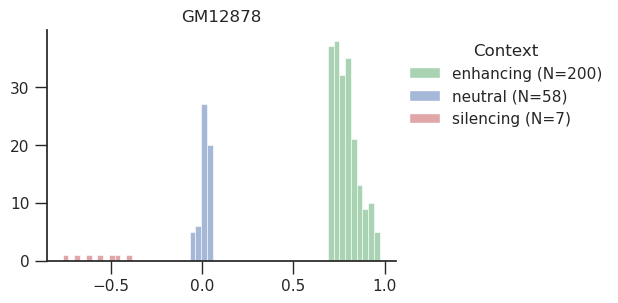

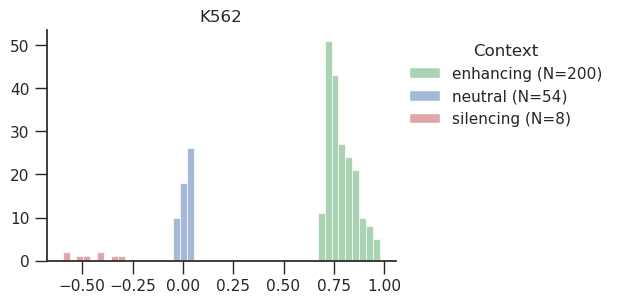

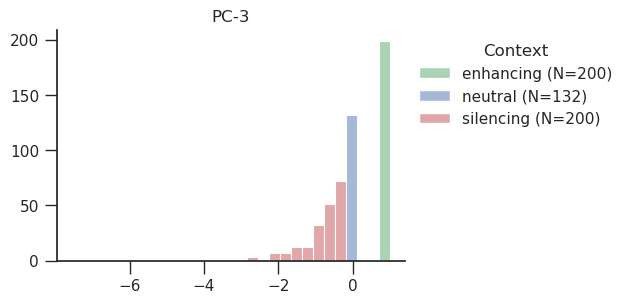

In [42]:
max_sample_size = 200
for k, df in res.groupby('cell_line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df_subsample = []
    for context_type, one_context_df in context_df.groupby('context'):
        print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)

    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta_mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    # context_df.to_csv(f'../results/summary_csvs//{model_name}/{k.split()[0]}_selected_contexts.csv')


,Unnamed: 0_enformer,Chromosome_enformer,Start,gene_name,gene_id_enformer,Strand_enformer,PC-3_enformer,Unnamed: 0_borzoi,Chromosome_borzoi,gene_id_borzoi,Strand_borzoi,PC-3_borzoi
0,18420,chr6,43576038,XPO5,ENSG00000124571.18,-,14.784539,18420,chr6,ENSG00000124571.18,-,11.195312
1,5721,chr2,74554730,DOK1,ENSG00000115325.14,+,14.805393,5721,chr2,ENSG00000115325.14,+,0.634766
2,24766,chr9,27529814,MOB3B,ENSG00000120162.10,-,14.813474,24766,chr9,ENSG00000120162.10,-,1.853516
3,50883,chr22,45413692,RIBC2,ENSG00000128408.9,+,14.859695,50883,chr22,ENSG00000128408.9,+,1.178711
4,228,chr1,12167002,TNFRSF1B,ENSG00000028137.19,+,14.868016,228,chr1,ENSG00000028137.19,+,0.744629
...,...,...,...,...,...,...,...,...,...,...,...,...
4288,44034,chr18,21612330,SNRPD1,ENSG00000167088.11,+,411.344482,44034,chr18,ENSG00000167088.11,+,7.023438
4289,14496,chr5,73498441,BTF3,ENSG00000145741.17,+,417.987427,14496,chr5,ENSG00000145741.17,+,6.863281
4290,33342,chr12,56725299,NACA,ENSG00000196531.14,-,419.924957,33342,chr12,ENSG00000196531.14,-,11.507812
4291,10844,chr3,49411976,RHOA,ENSG00000067560.14,-,432.647522,10844,chr3,ENSG00000067560.14,-,7.527344


In [75]:
import custom_model
model = custom_model.Borzoi('../data/borzoi/*/*', track_index=track_index, aggregate=True)


2024-01-22 08:49:06.390168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-01-22 08:49:07.349642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 08:49:07.822384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 50135 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [77]:
enformer_model_seq_length = 196608
delta_seq_length = (model.seq_length - enformer_model_seq_length) // 2

In [78]:
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, 5000)
cre_tiles_starts = np.array(cre_tiles)[:, 0]

In [82]:
cre_tiles_starts

array([  4644,   9644,  14644,  19644,  24644,  29644,  34644,  39644,
        44644,  49644,  54644,  59644,  64644,  69644,  74644,  79644,
        84644,  89644,  94644,  99644, 104644, 109644, 114644, 119644,
       124644, 129644, 134644, 139644, 144644, 149644, 154644, 159644,
       164644, 169644, 174644, 179644, 184644, 189644, 194644, 199644,
       204644, 209644, 214644, 219644, 224644, 229644, 234644, 239644,
       244644, 249644, 254644, 264644, 269644, 274644, 279644, 284644,
       289644, 294644, 299644, 304644, 309644, 314644, 319644, 324644,
       329644, 334644, 339644, 344644, 349644, 354644, 359644, 364644,
       369644, 374644, 379644, 384644, 389644, 394644, 399644, 404644,
       409644, 414644, 419644, 424644, 429644, 434644, 439644, 444644,
       449644, 454644, 459644, 464644, 469644, 474644, 479644, 484644,
       489644, 494644, 499644, 504644, 509644, 514644])

In [81]:
259644 * 2 // 32

16227

In [83]:
model.seq_length

524288